In [10]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
def load_csv(filePath, is_test=False):
    df = pd.read_csv(filePath)
    # split cabin
    df[["Deck", "Cabin_num", "Side"]] = df["Cabin"].str.split("/", expand=True)
    # map values to int index
    home_planet_dict = {'Europa':1, 'Earth':2, 'Mars':3}
    side_dict = {'P':1, 'S':2}
    destination_dict = {'TRAPPIST-1e':1,'PSO J318.5-22':2, '55 Cancri e':3}
    deck_dict = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8}
    #cabin_to_index )
    df['HomePlanet'] = df['HomePlanet'].map(home_planet_dict)
    df['Side'] = df['Side'].map(side_dict)
    df['Destination'] = df['Destination'].map(destination_dict)
    df['Deck'] = df['Deck'].map(deck_dict)
    # fill nan with zero
    columns_to_fill_zero = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
                             'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck',
                             'Cabin_num', 'Side']
    
    if is_test is False:
        columns_to_fill_zero.append('Transported')

    df[columns_to_fill_zero] = df[columns_to_fill_zero].fillna(0)
    # convert to int
    df['VIP'] = df['VIP'].astype(int)
    df['CryoSleep'] = df['CryoSleep'].astype(int)
    df['Cabin_num'] = df['Cabin_num'].astype(int)

    if is_test is False:
        df['Transported'] = df['Transported'].astype(int)
        transported_df = df['Transported'].copy()
        df = df.drop(['PassengerId', 'Name', 'Cabin', 'Transported'], axis=1) 
        return df, transported_df
    else:
        passanger_df = df['PassengerId'].copy()
        df = df.drop(['PassengerId', 'Name','Cabin'], axis=1) 
        return df, passanger_df

In [15]:
class Model(nn.Module):
    def __init__(self, lr):
        super(Model, self).__init__()

        fc1_dims = 10
        fc2_dims = 10
        input_dims = 13
        
        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.out = nn.Linear(fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
        self.loss = nn.MSELoss()
        self.to(self.device)

    def forward(self, input):
        p = self.fc1(input)
        p = F.relu(p)
        p = self.fc2(p)
        p = F.relu(p)
        p = self.out(p)
        p = F.relu(p)
        return p

In [13]:
def df_to_np(df):
    df_ = df.to_numpy(dtype=float)
    return df_

C:\Users\tr.DESKTOP-TRQB92B\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


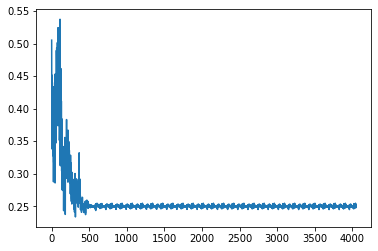

In [16]:
train_df, transported_df = load_csv("train.csv")
test_df, passanger_df = load_csv("test.csv", True)

train_array = df_to_np(train_df)
transported_array = df_to_np(transported_df)

learning_rate = 0.001
batch_size = 64
dataset_counter = int(transported_array.shape[0] / batch_size)
losses = []
epocs = 30
model = Model(lr=learning_rate)

for j in range(epocs):
    for i in range(dataset_counter):
        p_t = T.tensor(train_array[batch_size*i:batch_size*(i+1)], dtype=T.float32).to(model.device)
        a_t = T.tensor(transported_array[batch_size*i:batch_size*(i+1)], dtype=T.float32).to(model.device)
        pred = model.forward(p_t)
        # train the model
        model.train()
        model.optimizer.zero_grad()
        loss = model.loss(a_t, pred)
        loss.backward()
        model.optimizer.step()
        model.eval()
        # save loss for plotting later
        losses.append(loss.item())

plt.plot(losses)

In [17]:
test_array = df_to_np(test_df)
submission = pd.DataFrame(passanger_df)
transported = []

for i in range(test_array.shape[0]):
    t_t = T.tensor(test_array[i], dtype=T.float32).to(model.device)
    p = model.forward(t_t)
    if p[0].item() > 0.5:
        transported.append(True)
    else:
        transported.append(False)

submission['Transported'] = transported
submission.to_csv('submission.csv',index=False)